In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.simplefilter(action='ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


**1. Importing Libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

**2.Loading the data**

In [3]:
train=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
train.head(3)

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE


In [4]:
test=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
test.head(3)

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...


In [5]:
movies=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
movies.head(3)

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN


In [6]:
sample=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv')
sample.head()

,id,sentiment
0,0,NEGATIVE
1,1,NEGATIVE
2,2,NEGATIVE
3,3,NEGATIVE
4,4,NEGATIVE


**3. EXPLORATORY DATA ANALYSIS**


In [7]:
train.shape

(162758, 5)

In [8]:
print("No. of rows:", train.shape[0])
print("No. of columns:", train.shape[1])

No. of rows: 162758
No. of columns: 5


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


**There are total 5 columns, all are of string type except isFrequentReviewer is of Boolean type 
All are categorical variables and for our current analysis we will take reviewText as our input varable and sentiment is our target variable**


*3.1 To check for missing values:*

In [10]:
train.isnull().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

**Therefore, there are 6447 missing values in reviewText**

*3.2 visualizing the missing values*

<Axes: >

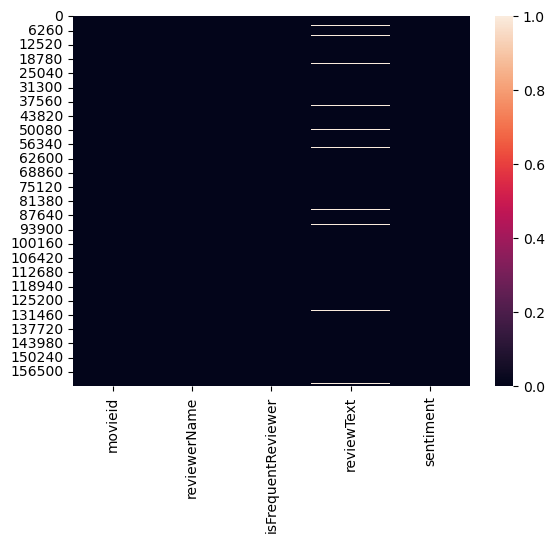

In [11]:
sns.heatmap(train.isnull())

In [12]:
percentmv= train.isnull().sum()*100 / len(train)
percentmv

movieid               0.000000
reviewerName          0.000000
isFrequentReviewer    0.000000
reviewText            3.961096
sentiment             0.000000
dtype: float64

**So, there are about 3.96% of missing values in the train dataset**

In [13]:
train.describe()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


*To check the number of label values*

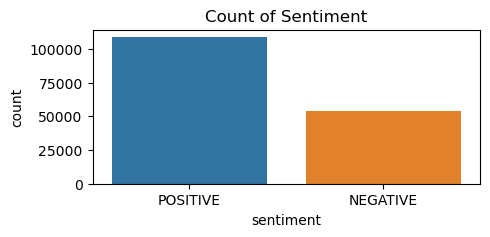

In [14]:
fig = plt.subplots(figsize=(5,2))
sns.countplot(x='sentiment', data=train)
plt.title("Count of Sentiment")
plt.show()

In [15]:
train['sentiment'].value_counts()

POSITIVE    108761
NEGATIVE     53997
Name: sentiment, dtype: int64

In [16]:
#In terms of percentage
n=len(train)
s0=len(train[train['sentiment']=='NEGATIVE'])
s1=len(train[train['sentiment']=='POSITIVE'])

print("% of positive reviews: ",(s1*100)/n)
print("% of negtive reviews: ",(s0*100)/n)

% of positive reviews:  66.82375059904889
% of negtive reviews:  33.17624940095111


**There are 66% of positive reviews and 33% negative reviews.**


**3.5 Similarly performing Exploratory Analysis on movies dataset**

In [17]:
movies.shape

(143258, 14)

In [18]:
print("No. of rows:", movies.shape[0])
print("No. of columns:", movies.shape[1])

No. of rows: 143258
No. of columns: 14


In [19]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


**There are total 14 columns, all are of string type except audienceScore and runtimeMinutes is of float type**

3.6 To check for missing values:

In [20]:
movies.isnull().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

**Therefore, there are missing values in audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,boxOffice,distributor and soundType**

<Axes: >

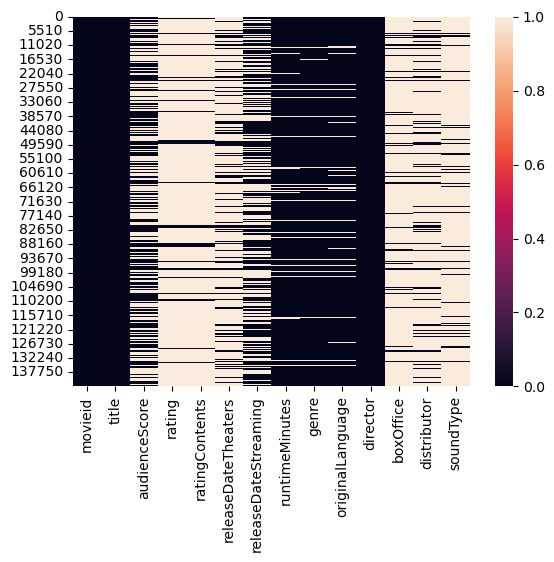

In [21]:
sns.heatmap(movies.isnull())

In [22]:
percentmv= movies.isnull().sum()*100 / len(movies)
percentmv

movieid                  0.000000
title                    0.000000
audienceScore           48.869871
rating                  90.233704
ratingContents          90.233704
releaseDateTheaters     78.519175
releaseDateStreaming    44.561560
runtimeMinutes           9.651817
genre                    7.736392
originalLanguage         9.673456
director                 0.000000
boxOffice               89.708777
distributor             83.941560
soundType               88.889277
dtype: float64

**The columns >50% missing values can be ignored for the analysis as it will lead to bias if imputed**

In [23]:
movies.describe(include='all')

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
count,143258,143258,73248.000000,13991,13991,30773,79420,129431.000000,132175,129400,143258,14743,23005,15917
unique,126404,126404,NaN,10,8353,12062,4726,NaN,2912,112,62208,4863,3694,551
top,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,NaN,R,['Language'],2018-09-14,2017-05-22,NaN,Drama,English,Joseph Brooks,$1.1M,Paramount Pictures,Surround
freq,367,367,NaN,7734,365,37,1232,NaN,27860,85034,4194,118,994,4075
mean,NaN,NaN,55.674967,NaN,NaN,NaN,NaN,93.708578,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,24.553648,NaN,NaN,NaN,NaN,28.129175,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,37.000000,NaN,NaN,NaN,NaN,84.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,57.000000,NaN,NaN,NaN,NaN,92.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,76.000000,NaN,NaN,NaN,NaN,103.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
movies.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


****The mean of audienceScore is 55.86 and that of runtimeMinutes is 93.57. ****

3.7 Visualizing the variables

<function matplotlib.pyplot.show(close=None, block=None)>

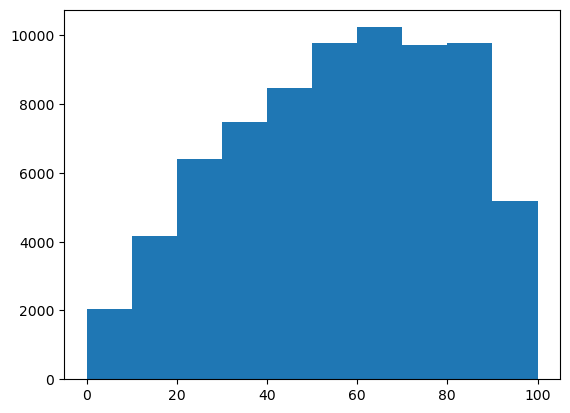

In [25]:
plt.hist(movies['audienceScore'])
plt.show

**It is right skewed.**

In [26]:
movies_dfg=movies.fillna(0)
movies_dfg.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,0,0,0,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,0,0,0
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,0.0,0,0,0,2020-02-11,114.0,Drama,English,Nathan Haack,0,0,0
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,0,0,0,0,120.0,Drama,Korean,Theresa Smith,0,0,0
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,0,0,0,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,0,0,0
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,0,0,0,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,0,0,0


In [27]:
mov=movies_dfg.nlargest(10,'runtimeMinutes')[['title','runtimeMinutes']]
mov

,title,runtimeMinutes
70385,Forrest Gump Captain Jack Sparrow Mythical,2700.0
136482,Kingdom Gandalf,1013.0
82899,Enchanted Voyage Gollum,940.0
130378,Majestic Harmony Whispering Enthralling,763.0
103264,Hulk Legend Enigma Myriad,632.0
123966,Galaxy Ferris Bueller Neo,593.0
100803,Wolverine Tony Montana,584.0
104605,Labyrinth Jon Snow Sherlock Holmes,561.0
119057,Hermione Granger Crown Michael Corleone,540.0
123535,The Bride Gandalf Norman Bates,540.0


<Axes: xlabel='runtimeMinutes', ylabel='title'>

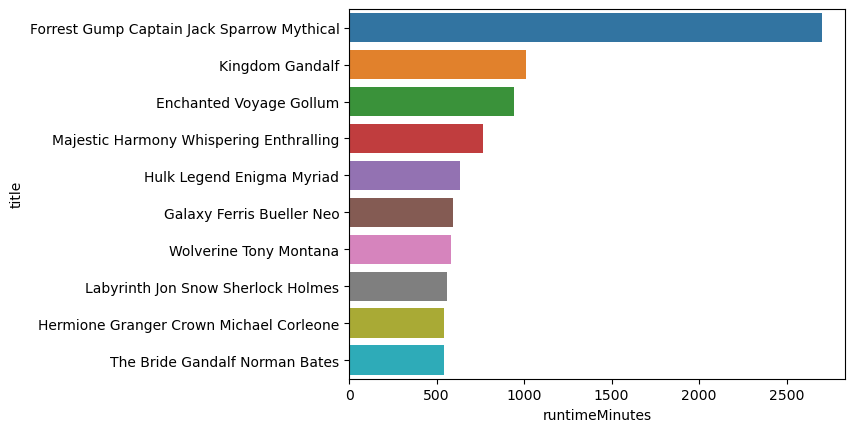

In [28]:
sns.barplot(x='runtimeMinutes',y='title',data=mov)

3.7 To check for any duplicate values:

In [29]:
movies.duplicated().sum()

1571

So, there are 1571 duplicate values

In [30]:
nmovies= movies.loc[movies.duplicated(keep='first'),:]
nmovies.head(3)

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
1126,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joseph Brooks,NaN,NaN,NaN
3772,supreme_indiana_jones,Supreme Indiana Jones,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN
5048,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joseph Brooks,NaN,NaN,NaN


3.8 To Remove the duplicates:

In [31]:
movies=movies.drop_duplicates(subset='movieid')
movies.shape

(126404, 14)

In [32]:
print("No. of rows:", movies.shape[0])
print("No. of columns:", movies.shape[1])

No. of rows: 126404
No. of columns: 14


Therefore, after removing the duplicates the final shape of train dataset is 126404 rows and 14 columns

3.8  Similarly performing Exploratory Analysis on test dataset

In [33]:
test.shape

(55315, 4)

In [34]:
print("No. of rows:", test.shape[0])
print("No. of columns:", test.shape[1])

No. of rows: 55315
No. of columns: 4


In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


There are total 4 columns, all are of string type except isTopCritic is of boolean type

In [36]:
test.describe()

,movieid,reviewerName,isTopCritic,reviewText
count,55315,55315,55315,52805
unique,16786,4495,2,52686
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review
freq,230,428,38428,12


3.6 To check for missing values:

In [37]:
test.isnull().sum()

movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

**There are 2510 missing values in reviewText**

**4. PREPROCESSING**

4.1 Using Tfidfvectorizer as it gives less importance to common words and also convert the raw data into matrix form

In [38]:
# Prepeocessing is done only on the required columns
x= train['reviewText'] 
y= train['sentiment']
x_test=test['reviewText']
x

0         Henry Selick’s first movie since 2009’s Corali...
1         With a cast that reads like the Vogue Oscar pa...
2         Creed II does not give us anything but another...
3         I know what you're thinking, but this is no Li...
4         Director Fernando Meirelles tells the story wi...
                                ...                        
162753    A top-notch thriller with genuine surprises an...
162754    Some people find Derek Zoolander funny and lik...
162755    This fun, gentle comedy focuses mainly on them...
162756    The film is rescued by a strong third act, but...
162757            A peerless exercise in stimulus response.
Name: reviewText, Length: 162758, dtype: object

In [39]:
train.isnull().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

4.2 Encoding the target variable by LabelEncoder so that when we predict it on the test data there is not discrepency

In [40]:
#Encoding the target variable
l=LabelEncoder()
y = l.fit_transform(y)

4.3 Imputation :  Since, in train dataset, our input variable is reviewText, it has about 4% missing values so, filling it blank will not create any bias

In [41]:
x= x.fillna('')

In [42]:
vect = TfidfVectorizer(max_features=15000)
x_t=vect.fit_transform(x)

In [43]:
x_t.shape

(162758, 15000)

Similarly, for movies data

**4.1 Imputation and Feature Scaling**

In [44]:
# finding the numerical variables
num_col=[col for col in movies.columns if movies[col].dtypes!='object']
num_col

['audienceScore', 'runtimeMinutes']

In [45]:
x1= movies[num_col]
x1.head(3)

,audienceScore,runtimeMinutes
0,50.0,75.0
1,NaN,114.0
2,43.0,120.0


In [46]:
#Splitting the dataset 
xm_train, xm_val, ym_train, ym_val = train_test_split(x1, movies['audienceScore'],
                                                    test_size=.2,
                                                    random_state=0)
xm_train.shape

(101123, 2)

In [47]:
#Performing imputation and Feature Scaling on numerical variables
pipe_num= Pipeline([
                    ('n_impute',SimpleImputer(strategy='most_frequent')),
                    ('scale',StandardScaler())
])
pipe_num.fit(xm_train)

Pipeline(steps=[('n_impute', SimpleImputer(strategy='most_frequent')),
                ('scale', StandardScaler())])

In [48]:
xm_train_trans= pipe_num.transform(xm_train)
xm_train_trans

array([[-1.12499192, -0.23012475],
       [-0.1671314 , -3.17747849],
       [-0.1671314 , -0.85643742],
       ...,
       [-0.1671314 , -0.15644091],
       [-0.1671314 ,  0.61723945],
       [-1.57574981, -0.41433436]])

In [49]:
display(pd.DataFrame(pipe_num.transform(xm_train), columns=pipe_num['scale'].get_feature_names_out(xm_train.columns)))

,audienceScore,runtimeMinutes
0,-1.124992,-0.230125
1,-0.167131,-3.177478
2,-0.167131,-0.856437
3,-0.167131,-0.451176
4,-0.167131,2.422494
...,...,...
101118,0.509005,0.211978
101119,2.650105,-0.119599
101120,-0.167131,-0.156441
101121,-0.167131,0.617239


In [50]:
# finding the categorical variables
cat_col=[col for col in movies.columns if movies[col].dtypes=='object']
cat_col

['movieid',
 'title',
 'rating',
 'ratingContents',
 'releaseDateTheaters',
 'releaseDateStreaming',
 'genre',
 'originalLanguage',
 'director',
 'boxOffice',
 'distributor',
 'soundType']

In [51]:
x2=movies[cat_col]
x2.head(3)

,movieid,title,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,NaN,NaN,NaN,2018-08-25,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,2020-02-11,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,NaN,NaN,NaN,NaN,Drama,Korean,Theresa Smith,NaN,NaN,NaN


In [52]:
xm_train1, xm_val1, ym_train1, ym_val1 = train_test_split(x2, movies['movieid'],
                                                    test_size=.2,
                                                    random_state=0)
xm_train1.shape

(101123, 12)

In [53]:
#Performing imputation and Encoding on categorical variables
pipe_cat= Pipeline([
                    ('c_impute',SimpleImputer(strategy='constant')),
                    ('ohe',OneHotEncoder(sparse=False))
])
pipe_cat.fit(xm_train1)

Pipeline(steps=[('c_impute', SimpleImputer(strategy='constant')),
                ('ohe', OneHotEncoder(sparse=False, sparse_output=False))])

In [54]:
xm_train_trans1= pipe_cat.transform(xm_train1)
xm_train_trans1

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

Similarly, for test data

In [55]:
x_test=x_test.fillna('')

In [56]:
x_test_tran=vect.transform(x_test)
x_test_tran.shape

(55315, 15000)

**5. Splitting the dataset**

In [57]:
x_train,x_val,y_train,y_val= train_test_split(x_t,y,test_size=0.2,random_state=0)
x_train.shape

(130206, 15000)

**6. MODEL**

**6.1 Multinomial Naive Bayes**

The reason for choosing this model is it works best for text data

6.12 Train and fit the model

In [58]:
from sklearn.naive_bayes import MultinomialNB

mnb=MultinomialNB()
mnb.fit(x_train,y_train)

MultinomialNB()

6.13 Predict and finding the score

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

y_pred=mnb.predict(x_val)
score= accuracy_score(y_val,y_pred)
print("Accuracy score: ", score)
print(classification_report(y_val,y_pred))
print ("F1_score:",f1_score(y_val,y_pred) )

Accuracy score:  0.7740538215777832
              precision    recall  f1-score   support

           0       0.83      0.41      0.54     10829
           1       0.76      0.96      0.85     21723

    accuracy                           0.77     32552
   macro avg       0.80      0.68      0.70     32552
weighted avg       0.78      0.77      0.75     32552

F1_score: 0.8498152042962449


**MultinomialNB : Accuracy score= 0.77 and f1_score= 0.84**

______________________________________________________________________

**6.2 Logistic Regression**

Logistic Regression uses sigmoid funtion which gives values in 0 and 1 so it will work better with the test data

In [60]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
lr.fit(x_train,y_train)

LogisticRegression()

In [61]:
from sklearn.metrics import accuracy_score
y_pred=lr.predict(x_val)
score= accuracy_score(y_val,y_pred)
print("Accuracy score: ", score)
print(classification_report(y_val,y_pred))
print ("F1_score:",f1_score(y_val,y_pred) )

Accuracy score:  0.7974932415826984
              precision    recall  f1-score   support

           0       0.76      0.57      0.65     10829
           1       0.81      0.91      0.86     21723

    accuracy                           0.80     32552
   macro avg       0.79      0.74      0.75     32552
weighted avg       0.79      0.80      0.79     32552

F1_score: 0.8573530684670649


**Logistic Regression : Accuracy score= 0.79 and f1_score= 0.85**

**6.3 Random Forest Classifier**

In [62]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(x_train,y_train)

RandomForestClassifier()

In [63]:
from sklearn.metrics import accuracy_score
y_pred=rfc.predict(x_val)
score= accuracy_score(y_val,y_pred)
print("Accuracy score: ", score)
print(classification_report(y_val,y_pred))
print ("F1_score:",f1_score(y_val,y_pred) )

Accuracy score:  0.7431187023838781
              precision    recall  f1-score   support

           0       0.78      0.32      0.45     10829
           1       0.74      0.95      0.83     21723

    accuracy                           0.74     32552
   macro avg       0.76      0.64      0.64     32552
weighted avg       0.75      0.74      0.71     32552

F1_score: 0.8320681206571072


**Random Forest : Accuracy score= 0.74 and f1_score= 0.83**

**6.4 Support Vector Machine**

In [64]:
from sklearn.svm import LinearSVC
svm=LinearSVC(random_state=0)
svm.fit(x_train,y_train)

LinearSVC(random_state=0)

In [65]:
from sklearn.metrics import accuracy_score
y_pred=svm.predict(x_val)
score= accuracy_score(y_val,y_pred)
print("Accuracy score: ", score)
print(classification_report(y_val,y_pred))
print ("F1_score:",f1_score(y_val,y_pred) )

Accuracy score:  0.7975239616613419
              precision    recall  f1-score   support

           0       0.73      0.61      0.67     10829
           1       0.82      0.89      0.85     21723

    accuracy                           0.80     32552
   macro avg       0.78      0.75      0.76     32552
weighted avg       0.79      0.80      0.79     32552

F1_score: 0.8543071243838279


**Support Vector Machine : Accuracy score= 0.79 and f1_score= 0.85**

**6.5 AdaBoostClassifier**

In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(ab, x_train, y_train, cv=5)
scores.mean()
ab.fit( x_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [67]:
from sklearn.metrics import accuracy_score
y_pred=ab.predict(x_val)
score= accuracy_score(y_val,y_pred)
print("Accuracy score: ", score)
print(classification_report(y_val,y_pred))
print ("F1_score:",f1_score(y_val,y_pred) )

Accuracy score:  0.7130744654706316
              precision    recall  f1-score   support

           0       0.65      0.29      0.40     10829
           1       0.72      0.92      0.81     21723

    accuracy                           0.71     32552
   macro avg       0.69      0.61      0.61     32552
weighted avg       0.70      0.71      0.68     32552

F1_score: 0.811084142394822


**AdaBoostClassifier : Accuracy score= 0.71 and f1_score= 0.81**

Summary of the results obtained from the models:
Top 3 Models:
1. Logistic Regression,SVM : Accuracy score= 0.79 and f1_score= 0.85
1. MultinomialNB  : Accuracy score= 0.77 and f1_score= 0.84
1. Random Forest  : Accuracy score= 0.74 and f1_score= 0.83
1. AdaBoostClassifier  : Accuracy score= 0.71 and f1_score= 0.81




Hyperparameter tuning is done to optimise the model and get better accuracy. Each model is hyperparameter tuned using Grid SearchCV

**1. Logistic Regresssion**

In [68]:
print(lr.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


In [69]:
from sklearn.model_selection import GridSearchCV

param_grid={ "C" : np.logspace(-4, 4, 20),
              "penalty": ['l1','l2'],
              "max_iter" : [100,200,500]}
gs= GridSearchCV(lr, param_grid,cv=5)
gs.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [100, 200, 500], 'penalty': ['l1', 'l2']})

In [70]:
print("Best Score:",gs.best_score_)
print("Best Parameter:",gs.best_params_)

Best Score: 0.7989109497718003
Best Parameter: {'C': 4.281332398719396, 'max_iter': 100, 'penalty': 'l2'}


**Using the best parameters retraining the model**

In [71]:
lrh=LogisticRegression(C= 4.28, penalty= 'l2')
lrh.fit(x_train,y_train)

from sklearn.metrics import accuracy_score
y_pred=lrh.predict(x_val)
score= accuracy_score(y_val,y_pred)
print("Accuracy score: ", score)
print ("F1_score:",f1_score(y_val,y_pred) )

Accuracy score:  0.800595969525682
F1_score: 0.8575754251234229


**Score before hyperparameter tuning: Accuracy =0.79, F1_score= 0.85 Score after hyperparameter tuning: 0.80, F1_score= 0.85 Therefore, there has been slight increase with hyperparameter tuning**

**2 . MultinomialNB**

In [72]:
print(mnb.get_params().keys())

dict_keys(['alpha', 'class_prior', 'fit_prior', 'force_alpha'])


In [73]:
param_grid={ "alpha" : [0.001, 0.1, 1, 10, 100,1000],
              }
gs= GridSearchCV(mnb, param_grid,cv=5)
gs.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.1, 1, 10, 100, 1000]})

In [74]:
print("Best Score:",gs.best_score_)
print("Best Parameter:",gs.best_params_)

Best Score: 0.7780133226490853
Best Parameter: {'alpha': 0.1}


**Using the best parameters retraining the model**

In [75]:
mnbh=MultinomialNB( alpha=0.1)
mnbh.fit(x_train,y_train)

from sklearn.metrics import accuracy_score
y_pred=mnbh.predict(x_val)
score= accuracy_score(y_val,y_pred)
print("Accuracy score: ", score)
print ("F1_score:",f1_score(y_val,y_pred) )

Accuracy score:  0.7776173507004178
F1_score: 0.8503256487129123


**Score before hyperparameter tuning: Accuracy =0.77, F1_score= 0.84
Score after hyperparameter tuning: 0.77, F1_score= 0.85
Therefore, there has been slight increase with hyperparameter tuning**

**3. Support Vector Machine**

In [76]:
print(svm.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])


In [77]:
from sklearn.model_selection import GridSearchCV
param_grid={ "C" : [1,10,20],
              }
gs= GridSearchCV(svm, param_grid,cv=5)
gs.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(random_state=0),
             param_grid={'C': [1, 10, 20]})

In [78]:
print("Best Score:",gs.best_score_)
print("Best Parameter:",gs.best_params_)

Best Score: 0.7936423847360253
Best Parameter: {'C': 1}


**Using the best parameters retraining the model**

In [79]:
from sklearn.svm import LinearSVC
svmh=LinearSVC(random_state=0, C=1)
svmh.fit(x_train,y_train)

from sklearn.metrics import accuracy_score
y_pred=svmh.predict(x_val)
score= accuracy_score(y_val,y_pred)
print("Accuracy score: ", score)
print ("F1_score:",f1_score(y_val,y_pred) )

Accuracy score:  0.7975239616613419
F1_score: 0.8543071243838279


**Score before hyperparameter tuning: Accuracy =0.79, F1_score= 0.85 Score after hyperparameter tuning: 0.79, F1_score= 0.85 Therefore, there has been no change with hyperparameter tuning**

________________________________________________________

In [80]:
# X= train['reviewText']
# y= train['sentiment']


In [81]:
# from sklearn.dummy import DummyClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3,random_state=42)

# model= DummyClassifier(strategy='prior')
# model.fit(X_train,y_train)

# y_pred=model.predict(X_test)
# score= accuracy_score(y_test,y_pred)
# score

#since, score is 0.66 so the accuracy obtained from other models should be more than this.

In [82]:
y_test_pred=lr.predict(x_test_tran)
y_test_pred.shape

(55315,)

In [83]:
submission=pd.DataFrame(columns=['id', 'sentiment'])
submission['id']=[i for i in range(len(y_test_pred))]
pred_list=[]
for j in y_test_pred:
    if j==1:
        pred_list.append('POSITIVE')
    else:
        pred_list.append('NEGATIVE')
    
submission["sentiment"]=pred_list
submission.to_csv('submission.csv',index=False)

In [84]:
z=pd.read_csv("submission.csv")
z

,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,NEGATIVE
55312,55312,POSITIVE
55313,55313,POSITIVE
